In [1]:
import os
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.stats import norm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from model_script.script_XGBoost_model_polars import DataCleaner, FeatureCreator, AnomalyFilter, WeightedPOICountsTransformer, data_loader, build_xgboost_model,save_model,plot_train_test_predictions

In [2]:
YEARS = ["2019","2020", "2021", "2022", "2023","2024"]
PREPROCESSED_FILE = "data_processed/data_dvf_preprocessed_test_explicabilite_IDF.csv"
BATCH_SIZE = 100_000
dep = ["75", "77", "78", "91", "92", "93", "94", "95"]

print("Starting preprocessing by year...")
# Charger la grille pour le pipeline
df_grid = pl.read_csv('data_pop_density/dataframe_densite&amenities_radius=500.csv')

# Définir le pipeline de preprocessing
pipeline_preprocess = Pipeline(steps=[
    ("cleaner", DataCleaner(nombre_lots_max=5, cutoff_valeur_fonciere_min=0.75e5, min_surface=15)),
    ("feature_creator", FeatureCreator(cutoff_prix_m2_min=3e3,cutoff_prix_m2_max=18e3)),
    ('weighted_poi', WeightedPOICountsTransformer(n_neighbors=4)),
    ("anomaly_filter", AnomalyFilter(contamination=0.1, target_elimination=True, prix_m2= True)),
    # ('weighted_poi', WeightedPOICountsTransformer(n_neighbors=4)),
])

pipeline_preprocess.set_params(weighted_poi__df_grid=df_grid)

# with open(PREPROCESSED_FILE, "w") as f:
#     pass

# # === 1. Charger et prétraiter chaque année séparément ===
# for year in YEARS:
#     print(f"Processing year {year}...")

#     # Charger les données de l'année en cours
#     df_year = data_loader('data_dvf', annees=[year],departements=dep)
#     print(f"Data loaded for {year}: {df_year.shape[0]} rows")

#     # Appliquer le préprocessing
#     df_processed = pipeline_preprocess.fit_transform(df_year)
#     df_processed.drop_nulls()
#     print(f"Data processed for {year}: {df_processed.shape[0]} rows")

#     # Sauvegarder les données prétraitées en ajoutant au CSV
#     with open(PREPROCESSED_FILE, mode="a") as f:
#         df_processed.write_csv(f,include_header=True)

# print("All years processed and saved!")

Starting preprocessing by year...


Pipeline(steps=[('cleaner',
                 DataCleaner(cutoff_valeur_fonciere_min=75000.0,
                             min_surface=15)),
                ('feature_creator',
                 FeatureCreator(cutoff_prix_m2_max=18000.0,
                                cutoff_prix_m2_min=3000.0)),
                ('weighted_poi',
                 WeightedPOICountsTransformer(df_grid=shape: (932_764, 12)
┌────────┬───────────┬───────────┬───────────┬───┬────────────┬───────────┬────────────┬───────────...
│ 932760 ┆ 51.07875  ┆ 2.5529168 ┆ 435.23727 ┆ … ┆ 0          ┆ 0         ┆ 0          ┆ 0         │
│ 932761 ┆ 51.087082 ┆ 2.5279167 ┆ 236.39545 ┆ … ┆ 0          ┆ 0         ┆ 0          ┆ 0         │
│ 932762 ┆ 51.087082 ┆ 2.5362499 ┆ 191.21591 ┆ … ┆ 0          ┆ 0         ┆ 0          ┆ 0         │
│ 932763 ┆ 51.087082 ┆ 2.5445833 ┆ 416.417   ┆ … ┆ 0          ┆ 0         ┆ 0          ┆ 0         │
└────────┴───────────┴───────────┴───────────┴───┴────────────┴───────────┴────────────┴───────────┘)),
                ('anomaly_filter',
                 AnomalyFilter(prix_m2=True, target_elimination=True))])

In [3]:
df_lazy = pl.scan_csv(
            PREPROCESSED_FILE,
            has_header = True,
            schema_overrides={
                'surface_reelle_bati': pl.Float32,
                'type_local': pl.Utf8,  # Optimisation mémoire
                'year': pl.Int32,  # Réduction mémoire
                'sin_month': pl.Float32,
                'cos_month': pl.Float32,
                'nombre_lots': pl.Float32,
                'total_surface_carrez': pl.Float32,
                'lot1_surface_carrez': pl.Float32,
                'lot2_surface_carrez': pl.Float32,
                'lot3_surface_carrez': pl.Float32,
                'lot4_surface_carrez': pl.Float32,
                'lot5_surface_carrez': pl.Float32,
                'nombre_pieces_principales': pl.Float32,
                'surface_terrain': pl.Float32,
                'longitude': pl.Float32,
                'latitude': pl.Float32,
                'prix_m2': pl.Float64,
                'densite_weighted': pl.Float32,
                'transport_pois_weighted': pl.Float32,
                'education_pois_weighted': pl.Float32,
                'health_pois_weighted': pl.Float32,
                'food_pois_weighted': pl.Float32,
                'shopping_pois_weighted': pl.Float32,
                'park_pois_weighted': pl.Float32,
                'entertainment_pois_weighted': pl.Float32,
                'cultural_pois_weighted': pl.Float32
            },
            ignore_errors = True
        ).drop_nulls()


# === 3. Séparation Train / Test (Lazy) ===
df = df_lazy.collect().sample(fraction=1.0,shuffle=True) # Convertit en DataFrame
df = df.with_columns(pl.lit(np.random.rand(len(df))).alias("split"))  # Ajoute une colonne random
df_lazy = df.lazy()  # Reconvertit en LazyFrame# Ajoute une colonne random
df_train = df_lazy.filter(pl.col("split") < 0.8).drop("split")  # 80% pour l'entraînement
df_test = df_lazy.filter(pl.col("split") >= 0.8).drop("split")  # 20% pour le test

df_train_features = df_train.drop("prix_m2")
df_train_target = df_train.select("prix_m2")
print(df_train_features.collect().shape)

df_test_features = df_test.drop("prix_m2")
df_test_target = df_test.select("prix_m2")
print(df_test_features.collect().shape)


(377022, 25)
(94599, 25)


In [4]:
# === 1. Préparation des données ===
# Caractéristiques pour le modèle physique
physical_features = ['surface_reelle_bati', 'type_local', 'nombre_pieces_principales','nombre_lots','total_surface_carrez',
                     'lot1_surface_carrez', 'lot2_surface_carrez','lot3_surface_carrez', 'lot4_surface_carrez',
                     'lot5_surface_carrez','surface_terrain']

# Caractéristiques pour le modèle localisation
contextual_features = ['year', 'sin_month', 'cos_month','longitude', 'latitude',
    'densite_weighted', 'transport_pois_weighted', 'education_pois_weighted',
    'health_pois_weighted', 'food_pois_weighted', 'shopping_pois_weighted',
    'park_pois_weighted', 'entertainment_pois_weighted', 'cultural_pois_weighted']

# === 2. Pipelines d'encodage ===
categorical_columns_physical = ['type_local']
numerical_columns_physical = ['surface_reelle_bati', 'nombre_pieces_principales','nombre_lots','total_surface_carrez',
                     'lot1_surface_carrez', 'lot2_surface_carrez','lot3_surface_carrez', 'lot4_surface_carrez',
                     'lot5_surface_carrez','surface_terrain']
numerical_columns_contextual = ['year', 'sin_month', 'cos_month','longitude', 'latitude',
    'densite_weighted', 'transport_pois_weighted', 'education_pois_weighted',
    'health_pois_weighted', 'food_pois_weighted', 'shopping_pois_weighted',
    'park_pois_weighted', 'entertainment_pois_weighted', 'cultural_pois_weighted']

# Catégories uniques pour l'encodage OneHot
unique_categories = [df_lazy.select(col).drop_nulls().unique().collect().to_series().to_list()
                      for col in categorical_columns_physical]

# Pipeline pour les caractéristiques physiques
physical_pipeline = ColumnTransformer([
    ('onehot', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', categories=unique_categories))
    ]), categorical_columns_physical),
    ('numeric', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', RobustScaler())
    ]), numerical_columns_physical)
])

# Pipeline pour les caractéristiques de localisation
contextual_pipeline = ColumnTransformer([
    ('numeric', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', RobustScaler())
    ]), numerical_columns_contextual)
])

# === 3. Paramètres des modèles ===
params_physical = {
    "objective": "reg:squarederror",
    "learning_rate": 0.5,
    "max_depth": 10,
    "n_jobs": 2,
    "subsample": 0.8,
    "gamma": 0.1,
    "min_child_weight": 10,
    "lambda": 1,
    "alpha": 0.5
}

params_contextual = {
    "objective": "reg:squarederror",
    "learning_rate": 0.3,
    "max_depth": 8,
    "n_jobs": 2,
    "subsample": 0.9,
    "gamma": 0.2,
    "min_child_weight": 5,
    "lambda": 1,
    "alpha": 0.3
}

In [53]:
class CombinedXGBModel(BaseEstimator, RegressorMixin):
    def __init__(self, physical_params, contextual_params, physical_weight=0.5, save = False):
        self.physical_params = physical_params
        self.contextual_params = contextual_params
        self.physical_model = xgb.XGBRegressor(**physical_params)
        self.contextual_model = xgb.XGBRegressor(**contextual_params)
        self.physical_weight = physical_weight
        self.contextual_weight = 1-physical_weight
        self.save = save

    def fit(self, X, y):
        # Décomposer le tuple X en X_physical et X_contextual
        X_physical, X_contextual = X
        self.physical_model.fit(X_physical, y)
        self.contextual_model.fit(X_contextual, y)
        return self

    def predict(self, X):
        # Décomposer le tuple X en X_physical et X_contextual
        X_physical, X_contextual = X
        pred_physical = self.physical_model.predict(X_physical)
        pred_contextual = self.contextual_model.predict(X_contextual)
        combined_preds = (self.physical_weight * pred_physical +
                          self.contextual_weight * pred_contextual)
        return combined_preds

    def save_models(self, directory='saved_models'):
        if not os.path.exists(directory):
            os.makedirs(directory)
        joblib.dump(self.physical_model, os.path.join(directory, 'physical_model.pkl'))
        joblib.dump(self.contextual_model, os.path.join(directory, 'contextual_model.pkl'))

    def load_models(self, directory='saved_models'):
        self.physical_model = joblib.load(os.path.join(directory, 'physical_model.pkl'))
        self.contextual_model = joblib.load(os.path.join(directory, 'contextual_model.pkl'))

class CustomGridSearchCV(GridSearchCV):
    def __init__(self, estimator, param_grid, **kwargs):
        super().__init__(estimator, param_grid, **kwargs)

    def fit(self, X, y=None, **fit_params):
        # Si X est un tuple, on va le passer tel quel
        if isinstance(X, tuple):
            return super().fit(X, y, **fit_params)
        else:
            # Si X est une matrice combinée, on décompose
            X_physical = X[:, :X.shape[1] // 2]
            X_contextual = X[:, X.shape[1] // 2:]
            X_split = (X_physical, X_contextual)
            return super().fit(X_split, y, **fit_params)

    def predict(self, X):
        # Si X est un tuple, on passe directement à la prédiction
        if isinstance(X, tuple):
            return super().predict(X)
        else:
            # Si X est une matrice combinée, on décompose
            X_physical = X[:, :X.shape[1] // 2]
            X_contextual = X[:, X.shape[1] // 2:]
            X_split = (X_physical, X_contextual)
            return super().predict(X_split)

In [54]:
def train_combined_model(df_features, df_target, save=False):
    # Préparation des données
    X_physical = physical_pipeline.fit_transform(df_features.select(physical_features).collect())
    X_contextual = contextual_pipeline.fit_transform(df_features.select(contextual_features).collect())

    X_combined = (X_physical, X_contextual)
    y_train = df_target.collect().to_numpy().ravel()

    # Entraînement du modèle combiné
    combined_model = CombinedXGBModel(physical_params=params_physical, contextual_params=params_contextual)
    combined_model.fit(X_combined, y_train)

    if save:
        combined_model.save_models()  # Sauvegarde des modèles

    return combined_model



# === 6. Prédiction combinée ===
def combined_prediction(model, df_features):
    X_physical = physical_pipeline.transform(df_features.select(physical_features).collect())
    X_contextual = contextual_pipeline.transform(df_features.select(contextual_features).collect())
    X_combined = (X_physical, X_contextual)  # Créer le tuple pour les prédictions
    return model.predict(X_combined)


def grid_search_combined_model(df_features, df_target, save=False):
    # Préparation des données
    X_physical = physical_pipeline.fit_transform(df_features.select(physical_features).collect())
    X_contextual = contextual_pipeline.fit_transform(df_features.select(contextual_features).collect())

    # Combiner les deux matrices en un seul tuple
    X_combined = (X_physical, X_contextual)

    y_train = df_target.collect().to_numpy().ravel()

    # Définir le modèle combiné avec les hyperparamètres
    combined_model = CombinedXGBModel(physical_params=params_physical, contextual_params=params_contextual)

    # Paramètres à tester dans GridSearch
    param_grid = {
        'physical_weight': [0.3, 0.5, 0.7]  # Poids du modèle physique (peut être élargi)
    }

    # Utiliser la version personnalisée de GridSearchCV
    grid_search = CustomGridSearchCV(estimator=combined_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

    # Ajustement du modèle
    grid_search.fit(X_combined, y_train)

    # Meilleur modèle et meilleurs paramètres
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Sauvegarder le meilleur modèle
    if save:
        best_model.save_models()  # Sauvegarde des modèles

    return best_model, best_params


In [51]:
combined_model = CombinedXGBModel(physical_params=params_physical, contextual_params=params_contextual)
combined_model.get_params

<bound method BaseEstimator.get_params of CombinedXGBModel(contextual_params={'alpha': 0.3, 'gamma': 0.2, 'lambda': 1,
                                    'learning_rate': 0.3, 'max_depth': 8,
                                    'min_child_weight': 5, 'n_jobs': 2,
                                    'objective': 'reg:squarederror',
                                    'subsample': 0.9},
                 physical_params={'alpha': 0.5, 'gamma': 0.1, 'lambda': 1,
                                  'learning_rate': 0.5, 'max_depth': 10,
                                  'min_child_weight': 10, 'n_jobs': 2,
                                  'objective': 'reg:squarederror',
                                  'subsample': 0.8})>

In [55]:
best_model, best_params = grid_search_combined_model(df_train_features, df_train_target)
y_pred_test = combined_prediction(best_model, df_test_features)

ValueError: Found input variables with inconsistent numbers of samples: [2, 377022]

In [43]:
# y_test = df_test_target.collect().to_numpy().ravel()
# dx = 100  # Taille des intervalles (ajuste selon l'échelle de tes données)

# # Tri des données
# bins = np.arange(min(y_test), max(y_test) + dx, dx)
# bin_centers = bins[:-1] + dx / 2  # Centres des intervalles
# mean_predictions = [np.mean(y_pred_test[(y_test >= bins[i]) & (y_test < bins[i+1])])
#                     for i in range(len(bins)-1)]
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred_test, alpha=0.6)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ligne idéale
# plt.plot(bin_centers, mean_predictions, color='green', linestyle='-', marker='o',
#         label="Moyenne par intervalle")
# plt.title("Prédictions vs Valeurs Réelles")
# plt.xlabel("Valeurs Réelles")
# plt.ylabel("Prédictions")

# plt.xlim(0.75*min(y_test),1.1*max(y_test))
# plt.ylim(0.75*min(y_pred_test),1.25*max(y_pred_test))
# plt.tight_layout()

In [44]:
combined_model = train_combined_model(df_train_features, df_train_target)


In [45]:
y_pred_test = combined_prediction(combined_model, df_test_features)

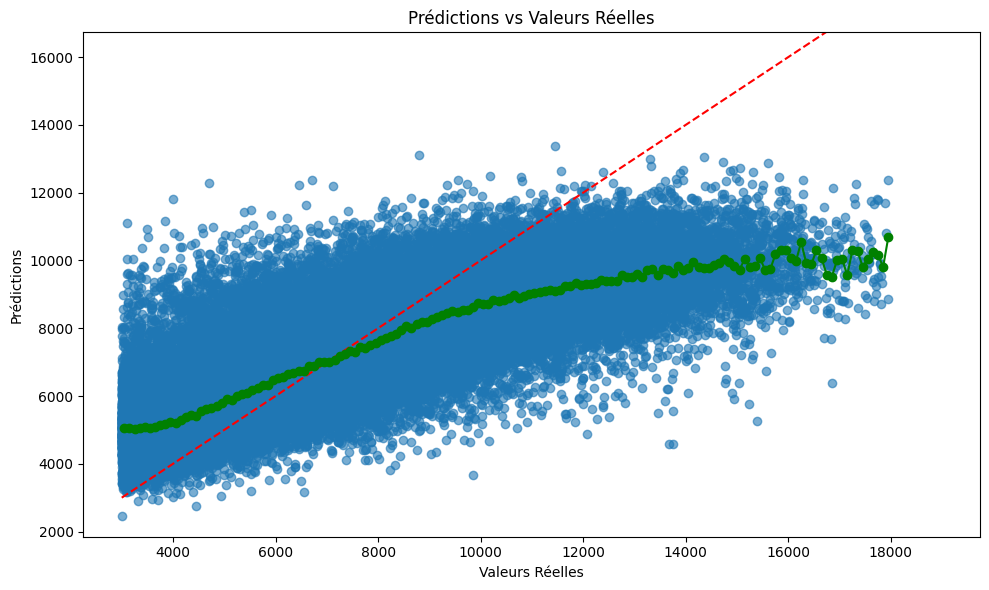

In [46]:
y_test = df_test_target.collect().to_numpy().ravel()
dx = 100  # Taille des intervalles (ajuste selon l'échelle de tes données)

# Tri des données
bins = np.arange(min(y_test), max(y_test) + dx, dx)
bin_centers = bins[:-1] + dx / 2  # Centres des intervalles
mean_predictions = [np.mean(y_pred_test[(y_test >= bins[i]) & (y_test < bins[i+1])])
                    for i in range(len(bins)-1)]
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ligne idéale
plt.plot(bin_centers, mean_predictions, color='green', linestyle='-', marker='o',
        label="Moyenne par intervalle")
plt.title("Prédictions vs Valeurs Réelles")
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")

plt.xlim(0.75*min(y_test),1.1*max(y_test))
plt.ylim(0.75*min(y_pred_test),1.25*max(y_pred_test))
plt.tight_layout()